# Attempt to Model Velocity Dependence
Using the multiple runs from the Si dataset

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from stopping_power_ml.io import get_charge_density_interpolator, load_directory
from stopping_power_ml.features import LocalChargeDensity, IonIonForce, ProjectedAGNIFingerprints
from sklearn.linear_model import BayesianRidge
from sklearn.neural_network import MLPRegressor
from glob import glob
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import os

In [18]:
import parsl
from parsl import *
workers = IPyParallelExecutor()
dfk = DataFlowKernel(executors=[workers])

Waiting for connection file: ~\.ipython\profile_default\security\ipcontroller-client.json


## Load in Data
Read in data from all velocities

Load in all directories

In [2]:
files = glob('datasets/Si/v**/*.out')
dirs = set([os.path.dirname(x) for x in files])
print('Found %d files in %d directories'%(len(files), len(dirs)))

Found 13 files in 8 directories


In [3]:
data = [load_directory(d) for d in tqdm(dirs, desc='Directories')]

A Jupyter Widget

In [4]:
data = pd.concat(data)

How much data from each type?

In [5]:
for gid, group in data.groupby('directory'):
    print(gid, len(group))

datasets/Si\v_0.125 16848
datasets/Si\v_0.25 8424
datasets/Si\v_0.5 4212
datasets/Si\v_0.75 2808
datasets/Si\v_1.0 2106
datasets/Si\v_1.5 1404
datasets/Si\v_2.0 1053
datasets/Si\v_5.0 842


## Determine the "start" value
Determine the point at which the effect of adding the particle has gone away

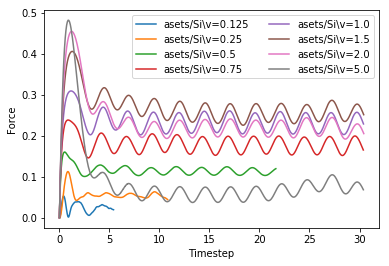

In [6]:
fig, ax = plt.subplots()

plot_max = 3000
for gid, group in data.groupby('directory'):
    ax.plot(group['displacement'].iloc[:plot_max], group['force'].iloc[:plot_max], label=gid[3:].replace("_","="))

ax.legend(ncol=2)
    
ax.set_xlabel('Timestep')
ax.set_ylabel('Force')

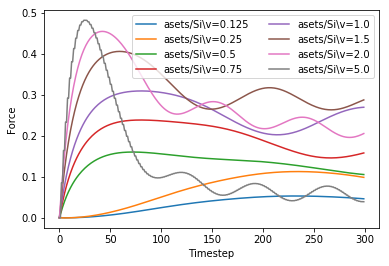

In [7]:
fig, ax = plt.subplots()

plot_max = 300
for gid, group in data.groupby('directory'):
    ax.plot(group['timestep'].iloc[:plot_max], group['force'].iloc[:plot_max], label=gid[3:].replace("_","="))

ax.legend(ncol=2)
    
ax.set_xlabel('Timestep')
ax.set_ylabel('Force')

After 125 seems good

In [8]:
data.query('timestep >= 125', inplace=True)

## Load in the Charge Density
Get the ground state charge density without the particle. Plot it to make sure it looks correct

In [9]:
charge, cell = get_charge_density_interpolator(os.path.join('datasets','Si',
                                                            'charge_density_ground_state_bulk_si',
                                                            'Si_4_val_elec_gs.cub'))

Plot the charge density along the [1,1,0] direction. Should be 8 bumps (one is split)

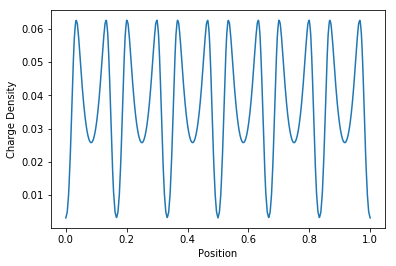

In [10]:
fig, ax = plt.subplots()

x = np.array(list(zip(np.linspace(0,1,1001), np.linspace(0,1,1001), [0,]*1001)))

ax.plot(x[:,0], charge(x))

ax.set_xlabel('Position')
ax.set_ylabel('Charge Density')

## Generate Features
Use the same features at the Al model

In [11]:
featurizers = [
    LocalChargeDensity(charge, np.linspace(1, -5, 7)),
    ProjectedAGNIFingerprints(etas=np.logspace(np.log10(0.8), np.log10(16), 8)),
    IonIonForce(acc=2)
]

In [20]:
def compute_features(featurizers, data, chunks=96):
    """Compute the features for each entry in the dataframe.
    
    :param featurizer: tools used to compute the features
    :param data: pd.DataFrame, data to be featurized
    :param threads_per_worker: int, number of threads to run on each Parsl worker
    :param chunks: int, number of pieces to evaluate in parallel"""
    
    @App('python', dfk)
    def compute_features(chunk):
        for f in featurizers:
            chunk = f.featurize_dataframe(chunk, 'atoms')
        return chunk

    chunks = [compute_features(chunk) for chunk in np.array_split(data, chunks)]
    return pd.concat([c.result() for c in tqdm(chunks, desc='Running')])

In [21]:
%%time
data = compute_features(featurizers, data)

A Jupyter Widget

Wall time: 4h 20min 56s


,atoms,energy,file_id,force,frame_id,position,velocity,file,timestep,displacement,...,log density t=1.0,AGNI eta=1.04e+01,AGNI eta=1.23e+00,AGNI eta=1.60e+01,AGNI eta=1.88e+00,AGNI eta=2.89e+00,AGNI eta=4.43e+00,AGNI eta=6.80e+00,AGNI eta=8.00e-01,ion-ion repulsion
timestep,,,,,,,,,,,,,,,,,,,,,
125,"(Atom('Si', [-10.15635, -10.15635, -10.1563500...",-858.087783,0,0.230723,125,"[2.53901892, 5.07818345, -8.8000425]","[-6.129e-05, 1.852e-05, 0.74979846]",datasets/Si\v_0.75\Si.out,125,1.356308,...,-3.652428,-0.000895,-0.000366,-0.001112,-0.001489,-0.001031,-0.000889,-0.000847,-8.196061e-07,0.020540
126,"(Atom('Si', [-10.15635, -10.15635, -10.1563500...",-858.085218,0,0.230474,126,"[2.53901803, 5.07818372, -8.78919368]","[-6.139e-05, 1.899e-05, 0.74979665]",datasets/Si\v_0.75\Si.out,126,1.367156,...,-3.652680,-0.001010,-0.000411,-0.001253,-0.001672,-0.001160,-0.001001,-0.000954,-9.218435e-07,0.022772
127,"(Atom('Si', [-10.15635, -10.15635, -10.1563500...",-858.082655,0,0.230221,127,"[2.53901714, 5.078184, -8.77834489]","[-6.149e-05, 1.947e-05, 0.74979483]",datasets/Si\v_0.75\Si.out,127,1.378005,...,-3.652931,-0.001124,-0.000455,-0.001394,-0.001854,-0.001288,-0.001113,-0.001062,-1.024001e-06,0.024987
128,"(Atom('Si', [-10.15635, -10.15635, -10.1563500...",-858.080095,0,0.229965,128,"[2.53901625, 5.07818428, -8.76749612]","[-6.159e-05, 1.996e-05, 0.74979302]",datasets/Si\v_0.75\Si.out,128,1.388854,...,-3.653183,-0.001237,-0.000500,-0.001533,-0.002035,-0.001415,-0.001224,-0.001168,-1.126064e-06,0.027185
129,"(Atom('Si', [-10.15635, -10.15635, -10.1563500...",-858.077537,0,0.229705,129,"[2.53901536, 5.07818458, -8.75664738]","[-6.168e-05, 2.045e-05, 0.74979121]",datasets/Si\v_0.75\Si.out,129,1.399703,...,-3.653435,-0.001349,-0.000544,-0.001672,-0.002214,-0.001541,-0.001334,-0.001274,-1.228017e-06,0.029364
130,"(Atom('Si', [-10.15635, -10.15635, -10.1563500...",-858.074983,0,0.229441,130,"[2.53901447, 5.07818488, -8.74579866]","[-6.176e-05, 2.096e-05, 0.7497894]",datasets/Si\v_0.75\Si.out,130,1.410551,...,-3.653686,-0.001460,-0.000587,-0.001810,-0.002392,-0.001666,-0.001443,-0.001378,-1.329843e-06,0.031521
131,"(Atom('Si', [-10.15635, -10.15635, -10.1563500...",-858.072431,0,0.229174,131,"[2.53901357, 5.07818518, -8.73494997]","[-6.184e-05, 2.147e-05, 0.7497876]",datasets/Si\v_0.75\Si.out,131,1.421400,...,-3.653938,-0.001571,-0.000630,-0.001946,-0.002568,-0.001790,-0.001551,-0.001482,-1.431523e-06,0.035032
132,"(Atom('Si', [-10.15635, -10.15635, -10.1563500...",-858.069883,0,0.228902,132,"[2.53901268, 5.0781855, -8.72410131]","[-6.191e-05, 2.199e-05, 0.74978579]",datasets/Si\v_0.75\Si.out,132,1.432249,...,-3.654157,-0.001680,-0.000673,-0.002082,-0.002742,-0.001912,-0.001658,-0.001584,-1.533033e-06,0.037143
133,"(Atom('Si', [-10.15635, -10.15635, -10.1563500...",-858.067337,0,0.228625,133,"[2.53901178, 5.07818582, -8.71325267]","[-6.198e-05, 2.253e-05, 0.74978399]",datasets/Si\v_0.75\Si.out,133,1.443097,...,-3.654345,-0.001788,-0.000716,-0.002217,-0.002914,-0.002033,-0.001764,-0.001686,-1.634352e-06,0.039228


In [13]:
X_cols = sum([f.feature_labels() for f in featurizers], [])
y_col = 'force'

## Fit on Entire Dataset
Use Bayesian Ridge Regression. Train on progressively larger slices, and see how the model does.

In [26]:
def fit_on_whole_dataset(model):

    model.fit(data[X_cols], data[y_col])

    fig, ax = plt.subplots()

    for gid, group in data.groupby('directory'):
        my_line, = ax.plot(group['displacement'], group['force'], linestyle='--', label=gid[3:].replace("_","="))

        ax.plot(group['displacement'], model.predict(group[X_cols]), color=my_line.get_color(), lw=5, alpha=0.3)

    ax.legend(ncol=2)

    ax.set_xlabel('Timestep (a.u.)')
    ax.set_ylabel('Force ($E_H / a_B$)')

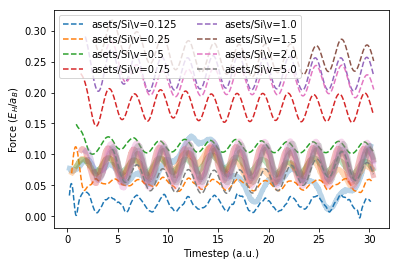

In [27]:
fit_on_whole_dataset(BayesianRidge(normalize=True))

You'll note the model predictions (thick, translucent lines) do not really differ based on velocity

## Add Velocity as a Variable
Can we fit the data if we just add velocity as a variable.

In [28]:
data['velocity_mag'] = data['velocity'].apply(np.linalg.norm)

In [29]:
X_cols += ['velocity_mag',]

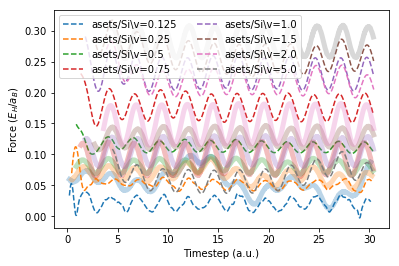

In [30]:
fit_on_whole_dataset(BayesianRidge(normalize=True))

The predictions do at least change significantly with the velocity, but not very well

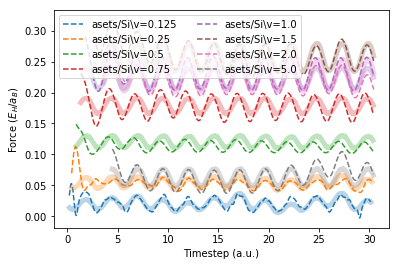

In [31]:
fit_on_whole_dataset(MLPRegressor(activation='tanh', hidden_layer_sizes=(128,64,32,16)))

With a somewhat complex NN model, we can at least fit the data

In [32]:
data[['directory',] + X_cols + [y_col,]].to_csv('Si_all_velocities.csv', index=False)